In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn import metrics
from scipy.stats import randint

# Data Preprocessing

## Load Dataframes

In [2]:
# read buinesses into dataframe
data_file = open("yelp-reviews/yelp_academic_dataset_business.json")
data = []

for line in data_file:
    data.append(json.loads(line))
    
business_df = pd.DataFrame(data)
data_file.close()

In [3]:
# read reviews into dataframe
file_review = "yelp-reviews/yelp_academic_dataset_review.json"
chunk_size = 7000000  # Define the number of lines to read at once

reviews = []  # List to store the parsed JSON data

with open(file_review, "r") as file:
    for line in file:
        reviews.append(json.loads(line))
        if len(reviews) >= chunk_size:
            break

review_df = pd.DataFrame(reviews)

# drop unnecessary columns
review_df = review_df.drop(columns=['useful', 'funny', 'cool', 'date'])

In [4]:
# merge dataframes
review_df = pd.merge(review_df, business_df, how="left", on="business_id")
review_df.dropna()

# filter for only restaurants
review_df = review_df.loc[review_df['categories'].str.contains('Restaurants') | review_df['categories'].str.contains('Food')]

# drop unnecessary columns
review_df = review_df.drop(columns=['address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars_y', 'review_count', 'is_open', 'attributes', 'hours'])
review_df = review_df.rename(columns={"stars_x": "stars"})

In [5]:
review_df.head()

,review_id,user_id,business_id,stars,text,name,categories
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B..."
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...,Kettle Restaurant,"Restaurants, Breakfast & Brunch"
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...",Zaika,"Halal, Pakistani, Restaurants, Indian"
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...,Melt,"Sandwiches, Beer, Wine & Spirits, Bars, Food, ..."
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,I am a long term frequent customer of this est...,Dmitri's,"Mediterranean, Restaurants, Seafood, Greek"


## Sentiment Analysis

## Full Reviews

### NLTK Sentiment Intensity Analyzer

In [15]:
sia = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

In [ ]:
review_sentiment_df = review_df.copy()

# Calculate sentiment score for each preprocessed review
review_sentiment_df['sentiment_score'] = review_sentiment_df['text'].apply(get_sentiment_score)

# Normalize sentiment scores to range from 1 to 5
review_sentiment_df['normalized_sentiment'] = round(((review_sentiment_df['sentiment_score'] + 1) / 2) * 4 + 1, 0)

# combined score
review_sentiment_df['score'] = review_sentiment_df['stars'] + review_sentiment_df['normalized_sentiment']

In [6]:
# the above cell takes a long time to run so we have saved the dataframe to another csv to load quickly
review_sentiment_df = pd.read_csv('reviews_with_sentiments.csv')
review_sentiment_df = review_sentiment_df.dropna()
review_sentiment_df.head()

,review_id,user_id,business_id,stars,text,name,categories,sentiment_score,normalized_sentiment,score
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B...",0.8597,5.0,8.0
1,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...,Kettle Restaurant,"Restaurants, Breakfast & Brunch",0.9201,5.0,8.0
2,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...",Zaika,"Halal, Pakistani, Restaurants, Indian",0.9588,5.0,10.0
3,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...,Melt,"Sandwiches, Beer, Wine & Spirits, Bars, Food, ...",0.9804,5.0,9.0
4,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,I am a long term frequent customer of this est...,Dmitri's,"Mediterranean, Restaurants, Seafood, Greek",0.7117,4.0,5.0


### Training Our Own Model

In [10]:
X = review_df['text']
y = review_df['stars']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create Document-Term Matrix (DTM)
vectorizer = CountVectorizer()
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

# Naive Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X_train_dtm, y_train)
nb_pred = nb_clf.predict(X_test_dtm)
nb_accuracy = accuracy_score(y_test, nb_pred)

# Logistic Regression
lr_clf = LogisticRegression()
lr_clf.fit(X_train_dtm, y_train)
lr_pred = lr_clf.predict(X_test_dtm)
lr_accuracy = accuracy_score(y_test, lr_pred)

print("Naive Bayes Accuracy:", nb_accuracy)
print("Logistic Regression Accuracy:", lr_accuracy)

/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Naive Bayes Accuracy: 0.6319823492920599
Logistic Regression Accuracy: 0.660465769565404


Logistic Regression performed better so we will use that model to get the sentiments for each review text

In [11]:
X_dtm = vectorizer.transform(X)
y_pred = lr_clf.predict(X_dtm)
review_sentiment_model_df = review_df.copy()
review_sentiment_model_df['normalized_sentiment'] = y_pred
review_sentiment_model_df['score'] = review_sentiment_model_df['stars'] + review_sentiment_model_df['normalized_sentiment']

In [12]:
review_sentiment_model_df.head()

,review_id,user_id,business_id,stars,text,name,categories,normalized_sentiment,score
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B...",2.0,5.0
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...,Kettle Restaurant,"Restaurants, Breakfast & Brunch",4.0,7.0
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...",Zaika,"Halal, Pakistani, Restaurants, Indian",5.0,10.0
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...,Melt,"Sandwiches, Beer, Wine & Spirits, Bars, Food, ...",4.0,8.0
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,I am a long term frequent customer of this est...,Dmitri's,"Mediterranean, Restaurants, Seafood, Greek",5.0,6.0


## Stemmed

In [ ]:
review_stemmed_df = review_df.copy()
# remove punctuation and make string lowercase
review_stemmed_df['text'] = review_stemmed_df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())

# remove stopwords, stem, and lemmatize
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_reviews(text):
    words = word_tokenize(text.lower())
    
    filtered_words = [word for word in words if word not in stop_words]
    
    stemmed_words = [ps.stem(word) for word in filtered_words]
    
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]

    return ' '.join(lemmatized_words)

review_stemmed_df['text'] = review_stemmed_df['text'].apply(clean_reviews)

In [30]:
# the above cell takes a long time to run so we have saved the dataframe to another csv to load quickly
review_stemmed_df = pd.read_csv('reviews_stemmed.csv')
review_stemmed_df = review_stemmed_df.dropna()
review_stemmed_df.head()

,review_id,user_id,business_id,stars,text,name,categories
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,decid eat awar go take 2 hour begin end tri mu...,Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B..."
1,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,famili diner buffet eclect assort larg chicken...,Kettle Restaurant,"Restaurants, Breakfast & Brunch"
2,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,wow yummi differ delici favorit lamb curri kor...,Zaika,"Halal, Pakistani, Restaurants, Indian"
3,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,cute interior owner gave u tour upcom patioroo...,Melt,"Sandwiches, Beer, Wine & Spirits, Bars, Food, ..."
4,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,long term frequent custom establish went order...,Dmitri's,"Mediterranean, Restaurants, Seafood, Greek"


### NLTK Sentiment Intensity Analyzer

In [16]:
review_stemmed_sentiment_df = review_stemmed_df.copy()

# Calculate sentiment score for each preprocessed review
review_stemmed_sentiment_df['sentiment_score'] = review_stemmed_sentiment_df['text'].apply(get_sentiment_score)

# Normalize sentiment scores to range from 1 to 5
review_stemmed_sentiment_df['normalized_sentiment'] = round(((review_stemmed_sentiment_df['sentiment_score'] + 1) / 2) * 4 + 1, 0)

# combined score
review_stemmed_sentiment_df['score'] = review_stemmed_sentiment_df['stars'] + review_stemmed_sentiment_df['normalized_sentiment']

In [21]:
# the above cell takes a long time to run so we have saved the dataframe to another csv to load quickly
review_stemmed_sentiment_df = pd.read_csv('reviews_with_sentiments_stemmed.csv')
review_stemmed_sentiment_df = review_stemmed_sentiment_df.dropna()
review_stemmed_sentiment_df.head()

,review_id,user_id,business_id,stars,text,name,categories,sentiment_score,normalized_sentiment,score
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,decid eat awar go take 2 hour begin end tri mu...,Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B...",0.8968,5.0,8.0
1,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,famili diner buffet eclect assort larg chicken...,Kettle Restaurant,"Restaurants, Breakfast & Brunch",0.8957,5.0,8.0
2,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,wow yummi differ delici favorit lamb curri kor...,Zaika,"Halal, Pakistani, Restaurants, Indian",0.8807,5.0,10.0
3,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,cute interior owner gave u tour upcom patioroo...,Melt,"Sandwiches, Beer, Wine & Spirits, Bars, Food, ...",0.9732,5.0,9.0
4,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,long term frequent custom establish went order...,Dmitri's,"Mediterranean, Restaurants, Seafood, Greek",0.6808,4.0,5.0


### Training Our Own Model

In [22]:
X = review_stemmed_df['text']
y = review_stemmed_df['stars']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create Document-Term Matrix (DTM)
vectorizer = CountVectorizer()
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

# Naive Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X_train_dtm, y_train)
nb_pred = nb_clf.predict(X_test_dtm)
nb_accuracy = accuracy_score(y_test, nb_pred)

# Logistic Regression
lr_clf = LogisticRegression()
lr_clf.fit(X_train_dtm, y_train)
lr_pred = lr_clf.predict(X_test_dtm)
lr_accuracy = accuracy_score(y_test, lr_pred)

print("Naive Bayes Accuracy:", nb_accuracy)
print("Logistic Regression Accuracy:", lr_accuracy)

/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Naive Bayes Accuracy: 0.6310662471152589
Logistic Regression Accuracy: 0.661725948136111


Logistic Regression performed better so we will use that model to get the sentiments for each review text

In [23]:
X_dtm = vectorizer.transform(X)
y_pred = lr_clf.predict(X_dtm)
review_stemmed_sentiment_model_df = review_stemmed_df.copy()
review_stemmed_sentiment_model_df['normalized_sentiment'] = y_pred
review_stemmed_sentiment_model_df['score'] = review_stemmed_sentiment_model_df['stars'] + review_stemmed_sentiment_model_df['normalized_sentiment']

In [25]:
review_stemmed_sentiment_model_df.head()

,review_id,user_id,business_id,stars,text,name,categories,normalized_sentiment,score
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,decid eat awar go take 2 hour begin end tri mu...,Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B...",1.0,4.0
1,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,famili diner buffet eclect assort larg chicken...,Kettle Restaurant,"Restaurants, Breakfast & Brunch",4.0,7.0
2,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,wow yummi differ delici favorit lamb curri kor...,Zaika,"Halal, Pakistani, Restaurants, Indian",5.0,10.0
3,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,cute interior owner gave u tour upcom patioroo...,Melt,"Sandwiches, Beer, Wine & Spirits, Bars, Food, ...",4.0,8.0
4,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,long term frequent custom establish went order...,Dmitri's,"Mediterranean, Restaurants, Seafood, Greek",5.0,6.0


## Lemmatized

In [ ]:
review_lemmatized_df = review_df.copy()
# remove punctuation and make string lowercase
review_lemmatized_df['text'] = review_lemmatized_df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())

# remove stopwords and lemmatize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_reviews(text):
    words = word_tokenize(text.lower())
    
    filtered_words = [word for word in words if word not in stop_words]
    
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    return ' '.join(lemmatized_words)

review_lemmatized_df['text'] = review_lemmatized_df['text'].apply(clean_reviews)

In [26]:
# the above cell takes a long time to run so we have saved the dataframe to another csv to load quickly
review_lemmatized_df = pd.read_csv('reviews_lemmatized.csv')
review_lemmatized_df = review_lemmatized_df.dropna()
review_lemmatized_df.head()

,review_id,user_id,business_id,stars,text,name,categories
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,decide eat aware going take 2 hour beginning e...,Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B..."
1,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,family diner buffet eclectic assortment large ...,Kettle Restaurant,"Restaurants, Breakfast & Brunch"
2,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,wow yummy different delicious favorite lamb cu...,Zaika,"Halal, Pakistani, Restaurants, Indian"
3,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,cute interior owner gave u tour upcoming patio...,Melt,"Sandwiches, Beer, Wine & Spirits, Bars, Food, ..."
4,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,long term frequent customer establishment went...,Dmitri's,"Mediterranean, Restaurants, Seafood, Greek"


### NLTK Sentiment Intensity Analyzer

In [27]:
review_lemmatized_sentiment_df = review_lemmatized_df.copy()

# Calculate sentiment score for each preprocessed review
review_lemmatized_sentiment_df['sentiment_score'] = review_lemmatized_sentiment_df['text'].apply(get_sentiment_score)

# Normalize sentiment scores to range from 1 to 5
review_lemmatized_sentiment_df['normalized_sentiment'] = round(((review_lemmatized_sentiment_df['sentiment_score'] + 1) / 2) * 4 + 1, 0)

# combined score
review_lemmatized_sentiment_df['score'] = review_lemmatized_sentiment_df['stars'] + review_lemmatized_sentiment_df['normalized_sentiment']

In [29]:
# the above cell takes a long time to run so we have saved the dataframe to another csv to load quickly
review_lemmatized_sentiment_df = pd.read_csv('reviews_with_sentiments_lemmatized.csv')
review_lemmatized_sentiment_df = review_lemmatized_sentiment_df.dropna()
review_lemmatized_sentiment_df.head()

,review_id,user_id,business_id,stars,text,name,categories,sentiment_score,normalized_sentiment,score
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,decide eat aware going take 2 hour beginning e...,Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B...",0.8968,5.0,8.0
1,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,family diner buffet eclectic assortment large ...,Kettle Restaurant,"Restaurants, Breakfast & Brunch",0.9360,5.0,8.0
2,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,wow yummy different delicious favorite lamb cu...,Zaika,"Halal, Pakistani, Restaurants, Indian",0.9652,5.0,10.0
3,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,cute interior owner gave u tour upcoming patio...,Melt,"Sandwiches, Beer, Wine & Spirits, Bars, Food, ...",0.9704,5.0,9.0
4,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,long term frequent customer establishment went...,Dmitri's,"Mediterranean, Restaurants, Seafood, Greek",0.8074,5.0,6.0


### Training Our Own Model

In [32]:
X = review_lemmatized_df['text']
y = review_lemmatized_df['stars']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create Document-Term Matrix (DTM)
vectorizer = CountVectorizer()
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

# Naive Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X_train_dtm, y_train)
nb_pred = nb_clf.predict(X_test_dtm)
nb_accuracy = accuracy_score(y_test, nb_pred)

# Logistic Regression
lr_clf = LogisticRegression()
lr_clf.fit(X_train_dtm, y_train)
lr_pred = lr_clf.predict(X_test_dtm)
lr_accuracy = accuracy_score(y_test, lr_pred)

print("Naive Bayes Accuracy:", nb_accuracy)
print("Logistic Regression Accuracy:", lr_accuracy)

/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Naive Bayes Accuracy: 0.6349073664045446
Logistic Regression Accuracy: 0.6656909430347768


Logistic Regression performed better so we will use that model to get the sentiments for each review text

In [33]:
X_dtm = vectorizer.transform(X)
y_pred = lr_clf.predict(X_dtm)
review_lemmatized_sentiment_model_df = review_lemmatized_df.copy()
review_lemmatized_sentiment_model_df['normalized_sentiment'] = y_pred
review_lemmatized_sentiment_model_df['score'] = review_lemmatized_sentiment_model_df['stars'] + review_lemmatized_sentiment_model_df['normalized_sentiment']

In [34]:
review_lemmatized_sentiment_model_df.head()

,review_id,user_id,business_id,stars,text,name,categories,normalized_sentiment,score
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,decide eat aware going take 2 hour beginning e...,Turning Point of North Wales,"Restaurants, Breakfast & Brunch, Food, Juice B...",1.0,4.0
1,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,family diner buffet eclectic assortment large ...,Kettle Restaurant,"Restaurants, Breakfast & Brunch",4.0,7.0
2,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,wow yummy different delicious favorite lamb cu...,Zaika,"Halal, Pakistani, Restaurants, Indian",5.0,10.0
3,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,cute interior owner gave u tour upcoming patio...,Melt,"Sandwiches, Beer, Wine & Spirits, Bars, Food, ...",4.0,8.0
4,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,long term frequent customer establishment went...,Dmitri's,"Mediterranean, Restaurants, Seafood, Greek",5.0,6.0


## Merge with Preprocessed Businesses

In [41]:
# to save time we can load the business dataframe from a saved csv
business_df = pd.read_csv('merged_data.csv')
business_df.head()

/var/folders/kn/1lfspxn113q7yyb3hkkgbc4w0000gn/T/ipykernel_3080/1342893057.py:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  business_df = pd.read_csv('merged_data.csv')


,Coffee & Tea,Food,Bakeries,business_id,Burgers,Sandwiches,Fast Food,Ice Cream & Frozen Yogurt,Bars,American (Traditional),...,Alcohol_nan.1,RestaurantsAttire_'casual',RestaurantsAttire_'dressy',RestaurantsAttire_'formal',RestaurantsAttire_None,RestaurantsAttire_nan,RestaurantsAttire_u'casual',RestaurantsAttire_u'dressy',RestaurantsAttire_u'formal',RestaurantsAttire_nan.1
0,1,1,1,MTSW4McQd7CbVtyjqoe9mw,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False
1,0,1,0,CF33F8-E6oudUQ46HnavjQ,1.0,1.0,1.0,1.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False
2,0,0,0,k0hlBqXX-Bt0vf1op7Jr1w,0.0,0.0,0.0,0.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
3,0,1,0,bBDDEgkFA1Otx9Lfe7BZUQ,1.0,0.0,1.0,1.0,0.0,0.0,...,False,True,False,False,False,False,False,False,False,False
4,0,1,0,eEOYSgkmpB90uNA7lDOMRA,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False


In [42]:
# add scores for each business to dataframe
def get_business_dataframe(df, business_df):
    avg_sentiment_by_business = df.groupby(by=['business_id'])['score'].mean()
    business_df = business_df.merge(avg_sentiment_by_business, on='business_id', how='left')

    business_df.replace({False: 0, True: 1, 'False': 0, 'True': 1, None: 0, 'None': 0}, inplace=True)
    business_df['score'] = round(business_df['score'], 0).astype(int)
    return business_df

In [45]:
business_sentiment_df = get_business_dataframe(review_sentiment_df, business_df)
business_sentiment_model_df = get_business_dataframe(review_sentiment_model_df, business_df)
business_stemmed_sentiment_df = get_business_dataframe(review_stemmed_sentiment_df, business_df)
business_stemmed_sentiment_model_df = get_business_dataframe(review_stemmed_sentiment_model_df, business_df)
business_lemmatized_sentiment_df = get_business_dataframe(review_lemmatized_sentiment_df, business_df)
business_lemmatized_sentiment_model_df = get_business_dataframe(review_lemmatized_sentiment_model_df, business_df)

In [46]:
# final dataframe (looks the same for each except different scores based on what preprocessing models were used)
business_sentiment_df.head()

,Coffee & Tea,Food,Bakeries,business_id,Burgers,Sandwiches,Fast Food,Ice Cream & Frozen Yogurt,Bars,American (Traditional),...,RestaurantsAttire_'casual',RestaurantsAttire_'dressy',RestaurantsAttire_'formal',RestaurantsAttire_None,RestaurantsAttire_nan,RestaurantsAttire_u'casual',RestaurantsAttire_u'dressy',RestaurantsAttire_u'formal',RestaurantsAttire_nan.1,score
0,1,1,1,MTSW4McQd7CbVtyjqoe9mw,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,9
1,0,1,0,CF33F8-E6oudUQ46HnavjQ,1.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,5
2,0,0,0,k0hlBqXX-Bt0vf1op7Jr1w,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,7
3,0,1,0,bBDDEgkFA1Otx9Lfe7BZUQ,1.0,0.0,1.0,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,6
4,0,1,0,eEOYSgkmpB90uNA7lDOMRA,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,9


# Models

### NLTK Sentiment Intensity Analyzer

In [47]:
# run Random Forest, SVM, KNN, Naive Bayes, and Logistic Regression models on the given features/targets
def run_models(df):
    X = df.drop(['business_id','stars','score'], axis=1)
    y = df['score']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Random Forest classifier
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    rf_pred = rf_clf.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    print("Random Forest Accuracy:", rf_accuracy)

    # Support Vector Machine (SVM)
    svm_model = SVC()
    svm_model.fit(X_train, y_train)
    svm_pred = svm_model.predict(X_test)
    svm_accuracy = accuracy_score(y_test, svm_pred)
    print("SVM Accuracy:", svm_accuracy)

    # K-Nearest Neighbors (KNN)
    knn_model = KNeighborsClassifier()
    knn_model.fit(X_train, y_train)
    knn_pred = knn_model.predict(X_test)
    knn_accuracy = accuracy_score(y_test, knn_pred)
    print("KNN Accuracy:", knn_accuracy)

    # Naive Bayes
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)
    nb_pred = nb_model.predict(X_test)
    nb_accuracy = accuracy_score(y_test, nb_pred)
    print("Naive Bayes Accuracy:", nb_accuracy)

    # Logistic Regression
    lr_model = LogisticRegression()
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)
    lr_accuracy = accuracy_score(y_test, lr_pred)
    print("Logistic Regression Accuracy:", lr_accuracy)

In [48]:
print('Uncleaned reviews with NLTK')
run_models(business_sentiment_df)
print('\nUncleaned reviews with our trained model')
run_models(business_sentiment_model_df)
print('\nStemmed reviews with NLTK')
run_models(business_stemmed_sentiment_df)
print('\nStemmed reviews with our trained model')
run_models(business_stemmed_sentiment_model_df)
print('\nLemmatized reviews with NLTK')
run_models(business_lemmatized_sentiment_df)
print('\nLemmatized reviews with our trained model')
run_models(business_lemmatized_sentiment_model_df)

Uncleaned reviews with NLTK
Random Forest Accuracy: 0.3744318731263901
SVM Accuracy: 0.335557489604487
KNN Accuracy: 0.31747413209554204
Naive Bayes Accuracy: 0.2702833381684557


/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.3733681462140992

Uncleaned reviews with our trained model
Random Forest Accuracy: 0.3113818779615124
SVM Accuracy: 0.28150082197079584
KNN Accuracy: 0.26622183541243594
Naive Bayes Accuracy: 0.23643748186829128


/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.29088095928827

Stemmed reviews with NLTK
Random Forest Accuracy: 0.41001837346484865
SVM Accuracy: 0.37133739483608935
KNN Accuracy: 0.3543177642394353
Naive Bayes Accuracy: 0.29368533023885507


/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.4067304902814041

Stemmed reviews with our trained model
Random Forest Accuracy: 0.30393578957547623
SVM Accuracy: 0.2770525094284885
KNN Accuracy: 0.2673822647712987
Naive Bayes Accuracy: 0.2410791993037424


/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.29213809109370464

Lemmatized reviews with NLTK
Random Forest Accuracy: 0.4013151532733778
SVM Accuracy: 0.35460787157915097
KNN Accuracy: 0.3416497437385166
Naive Bayes Accuracy: 0.2949424620442897


/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.38990426457789384

Lemmatized reviews with our trained model
Random Forest Accuracy: 0.3066434580794894
SVM Accuracy: 0.27772942655449184
KNN Accuracy: 0.2568416980949618
Naive Bayes Accuracy: 0.23634077942171938
Logistic Regression Accuracy: 0.2785997485736389


/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stemmed reviews using NLTK for sentiment analysis had the highest accuracy with the random forest classifier so we will be using that as our base model for fine-tuning.

# Fine-tuning

## Base Model

In [49]:
X = business_stemmed_sentiment_df.drop(['business_id','stars','score'], axis=1)
y = business_stemmed_sentiment_df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Random Forest classifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(rf_accuracy)

0.4079876220868388


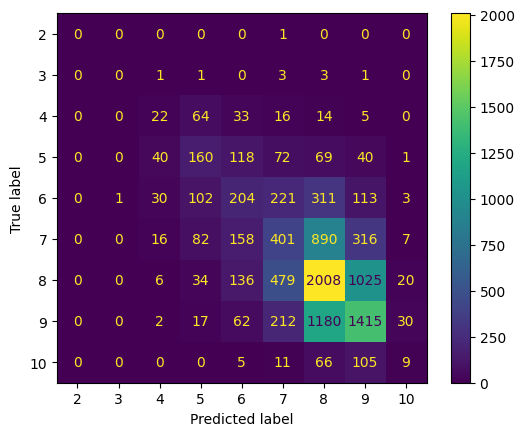

In [51]:
# confusion matrix for Random Forest Classifier
y_pred = rf_clf.predict(X_test)

# Calculate confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=[2,3,4,5,6,7,8,9,10])
cm_display.plot()

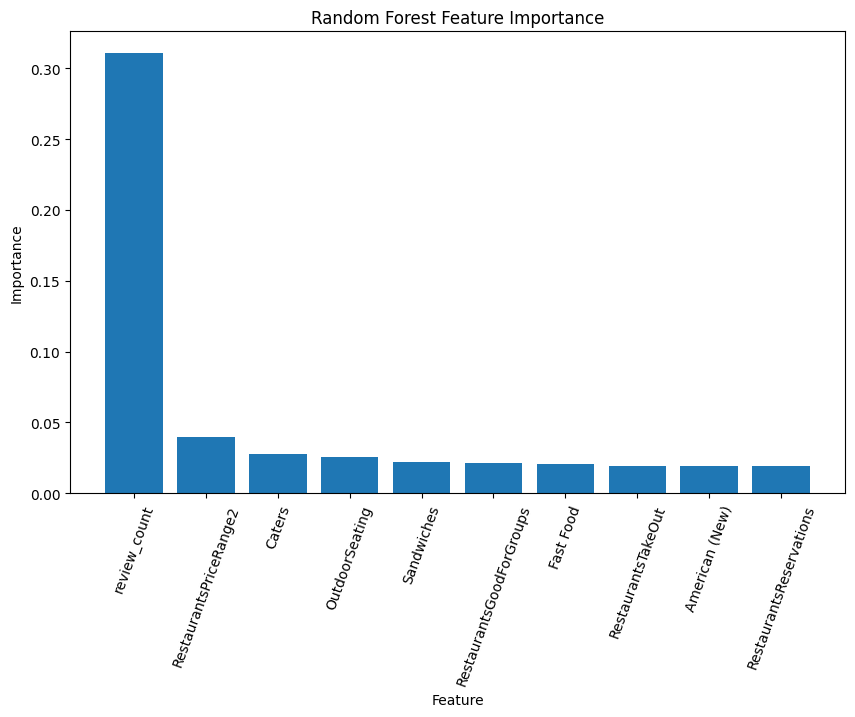

In [53]:
# plot feature importance
importances = rf_clf.feature_importances_

sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = np.array(list(business_stemmed_sentiment_df.drop(['business_id','stars', 'score'], axis=1).columns))[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(10), sorted_importances[:10])
plt.xticks(range(10), sorted_features[:10], rotation=70)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance")
plt.show()

## Hyperparameter Tuning

## Random Search

In [54]:
# Define the parameter grid
param_dist = {
    'n_estimators': randint(100, 1000),  # Number of trees in the forest
    'max_depth': randint(10, 100),        # Maximum depth of the trees
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 20),   # Minimum number of samples required at each leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider when looking for the best split
}

# Perform random search
random_search = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_dist, cv=5, n_jobs=-1)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

best_params = random_search.best_params_
best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

python(6483) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6484) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6486) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6487) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6489) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6491) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6493) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6495) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6497) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6499) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best Parameters: {'max_depth': 56, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 175}
Best Score: 0.4445386971109907
Accuracy: 0.45053669857847406


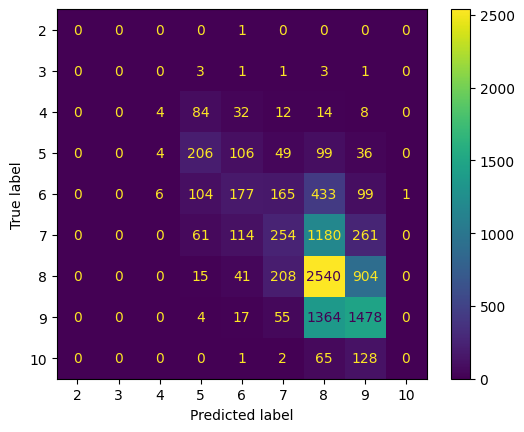

In [55]:
# confusion matrix for Random Forest Classifier
y_pred = best_rf.predict(X_test)

# Calculate confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=[2,3,4,5,6,7,8,9,10])
cm_display.plot()

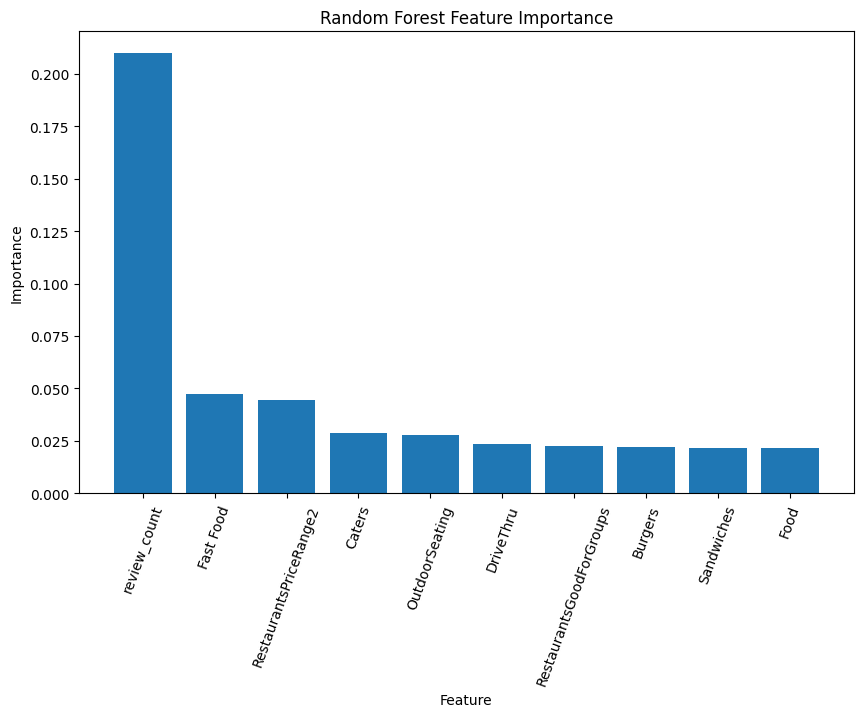

In [57]:
# plot feature importance
importances = best_rf.feature_importances_

sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = np.array(list(business_stemmed_sentiment_df.drop(['business_id','stars', 'score'], axis=1).columns))[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(10), sorted_importances[:10])
plt.xticks(range(10), sorted_features[:10], rotation=70)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance")
plt.show()

In [70]:
# Five Guys prediction

# data for Five Guys
new_data = [[0, 1, 0, 1, 1,
       1, 1, 0,
       1, 0, 0, 0, 0,
       0, 0, 0, 0, 0,
       0, 0, 0, 0, 0,
       0, 0, 0, 0, 0,
       0, 0, 1, 0,
       0, 0, 0, 0,
       0, 0, 0, 0, 0,
       1, 0, 0, 0, 1,
       0, 0, 1,
       0, 1,
       1, 1114,
       0, 0, 1,
       0, 0, 0,
       0, 0, 0,
       0, 0,
       0, 1,
       0, 0,
       0, 0,
       0]]
new_data = np.array(new_data)

five_guys_pred = best_rf.predict(new_data)
print(f'Predicted accuracy for Five Guys: {five_guys_pred}')

Predicted accuracy for Five Guys: [8]


/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


After checking Yelp, the rating for the Huntington Five Guys is 3.7/5 which is around a 7/10

## User fine-tuning

In [78]:
for user_id in ['smOvOajNG0lS4Pq7d8g4JQ', 'DBYhpb5hrAYgQjQaMhNYyQ', 'ZEpBNNP_btQrZ5qaByoZkg']:
    # average this user's reviews
    user_business_df = business_df.copy()
    user_df = review_stemmed_sentiment_df[review_stemmed_sentiment_df['user_id'] == user_id]
    avg_sentiment_by_business = user_df.groupby(by=['business_id'])['score'].mean()
    user_business_df = user_business_df.merge(avg_sentiment_by_business, on='business_id', how='inner')

    user_business_df.replace({False: 0, True: 1, 'False': 0, 'True': 1, None: 0, 'None': 0}, inplace=True)
    user_business_df['score'] = round(user_business_df['score'], 0).astype(int)
    # these columns had nan values so we removed them
    user_business_df = user_business_df.drop(['CoatCheck','Caters','HappyHour', 'DriveThru', 'RestaurantsReservations', 'RestaurantsGoodForGroups'], axis=1)

    # fine-tune
    X = user_business_df.drop(['business_id','stars','score'], axis=1)
    y = user_business_df['score']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Random Forest classifier
    best_rf.fit(X_train, y_train)
    rf_pred = best_rf.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    print(f'Accuracy for {user_id}: {rf_accuracy}')

Accuracy for smOvOajNG0lS4Pq7d8g4JQ: 0.11764705882352941
Accuracy for DBYhpb5hrAYgQjQaMhNYyQ: 0.7
Accuracy for ZEpBNNP_btQrZ5qaByoZkg: 0.5


For our neutral user (some positive and some negative reviews), we get an accuracy of approximately 11.76%, for our mostly positive user we get a higher accuracy of about 70%, and for our mostly negative user we get an accuracy of 50%.